In [ ]:
!pip install catboost

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
# import optuna
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

import random
import os
# Set the seed value all over the place to make this reproducible.
def seed_all(SEED=123):
    random.seed(SEED)

    np.random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
seed_all()

## Data Preprocessing

In [129]:
path='/content'   # the path where you have the csv files
power_consumption_prediction=pd.read_csv(path+'/imgs_202307101549519358.csv')
ener_con=pd.read_csv(path+'/imgs_2023071012133740345.csv')
cell_data=pd.read_csv(path+'/imgs_2023071012130978799.csv')
base_station_info=pd.read_csv(path+'/imgs_2023071012123392536.csv')
sub=pd.read_csv(path+'/SampleSubmission (4).csv')


In [130]:
power_consumption_prediction.head()

,Time,BS,Energy,w
0,2023-01-01 06:00:00,B_0,NaN,1
1,2023-01-01 11:00:00,B_0,NaN,1
2,2023-01-01 12:00:00,B_0,NaN,1
3,2023-01-01 13:00:00,B_0,NaN,1
4,2023-01-01 23:00:00,B_0,NaN,1


In [131]:
ener_con.head()

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812


In [132]:
base_station_info.head()

,BS,CellName,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower
0,B_0,Cell0,Type1,Mode2,365.0,20,4,6.875934
1,B_1,Cell0,Type2,Mode2,532.0,20,4,6.875934
2,B_2,Cell0,Type1,Mode2,365.0,20,4,6.875934
3,B_3,Cell0,Type2,Mode2,532.0,20,4,6.875934
4,B_4,Cell0,Type2,Mode2,532.0,20,4,6.875934


In [133]:
cell_data['ID']=cell_data['Time']+'_'+cell_data['BS']
#cell_data.drop(['Time'],axis=1,inplace=True)
cell_data.drop(['ESMode4'],axis=1,inplace=True)
cell_data.head()

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode5,ESMode6,ID
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0.0,0.0,1/1/2023 1:00_B_0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0.0,0.0,1/1/2023 2:00_B_0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0.0,0.0,1/1/2023 3:00_B_0
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0.0,0.0,1/1/2023 4:00_B_0
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0.0,0.0,1/1/2023 5:00_B_0


In [134]:
cell_data['Time']=pd.to_datetime(cell_data['Time'])

In [135]:
cell_data['Time_day']=cell_data['Time'].dt.day
cell_data['Time_hour']=cell_data['Time'].dt.hour
cell_data['Time_month']=cell_data['Time'].dt.month


In [136]:
cell_data.drop(['Time'],axis=1,inplace=True)

In [137]:
data=pd.merge(cell_data,base_station_info,on=['CellName','BS'],how='inner')
ener_con['ID']=ener_con['Time']+'_'+ener_con['BS']

In [138]:
data=pd.merge(data,ener_con,on='ID',how='left')

In [139]:
data['split'] = data['Energy'].isna().apply(lambda x: 'test' if x == True else 'train')

In [140]:
data

,BS_x,CellName,load,ESMode1,ESMode2,ESMode3,ESMode5,ESMode6,ID,Time_day,...,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,Time,BS_y,Energy,split
0,B_0,Cell0,0.487936,0.0,0.0,0.0,0.0,0.0,1/1/2023 1:00_B_0,1,...,Type1,Mode2,365.00,20,4,6.875934,1/1/2023 1:00,B_0,64.275037,train
1,B_0,Cell0,0.344468,0.0,0.0,0.0,0.0,0.0,1/1/2023 2:00_B_0,1,...,Type1,Mode2,365.00,20,4,6.875934,1/1/2023 2:00,B_0,55.904335,train
2,B_0,Cell0,0.193766,0.0,0.0,0.0,0.0,0.0,1/1/2023 3:00_B_0,1,...,Type1,Mode2,365.00,20,4,6.875934,1/1/2023 3:00,B_0,57.698057,train
3,B_0,Cell0,0.222383,0.0,0.0,0.0,0.0,0.0,1/1/2023 4:00_B_0,1,...,Type1,Mode2,365.00,20,4,6.875934,1/1/2023 4:00,B_0,55.156951,train
4,B_0,Cell0,0.175436,0.0,0.0,0.0,0.0,0.0,1/1/2023 5:00_B_0,1,...,Type1,Mode2,365.00,20,4,6.875934,1/1/2023 5:00,B_0,56.053812,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125570,B_745,Cell3,0.071000,0.0,0.0,0.0,0.0,0.0,1/2/2023 19:00_B_745,2,...,Type1,Mode2,426.98,2,2,6.877429,1/2/2023 19:00,B_745,60.837070,train
125571,B_745,Cell3,0.064962,0.0,0.0,0.0,0.0,0.0,1/2/2023 20:00_B_745,2,...,Type1,Mode2,426.98,2,2,6.877429,1/2/2023 20:00,B_745,55.904335,train
125572,B_745,Cell3,0.081865,0.0,0.0,0.0,0.0,0.0,1/2/2023 21:00_B_745,2,...,Type1,Mode2,426.98,2,2,6.877429,1/2/2023 21:00,B_745,61.883408,train
125573,B_745,Cell3,0.097615,0.0,0.0,0.0,0.0,0.0,1/2/2023 22:00_B_745,2,...,Type1,Mode2,426.98,2,2,6.877429,1/2/2023 22:00,B_745,65.470852,train


## EDAs

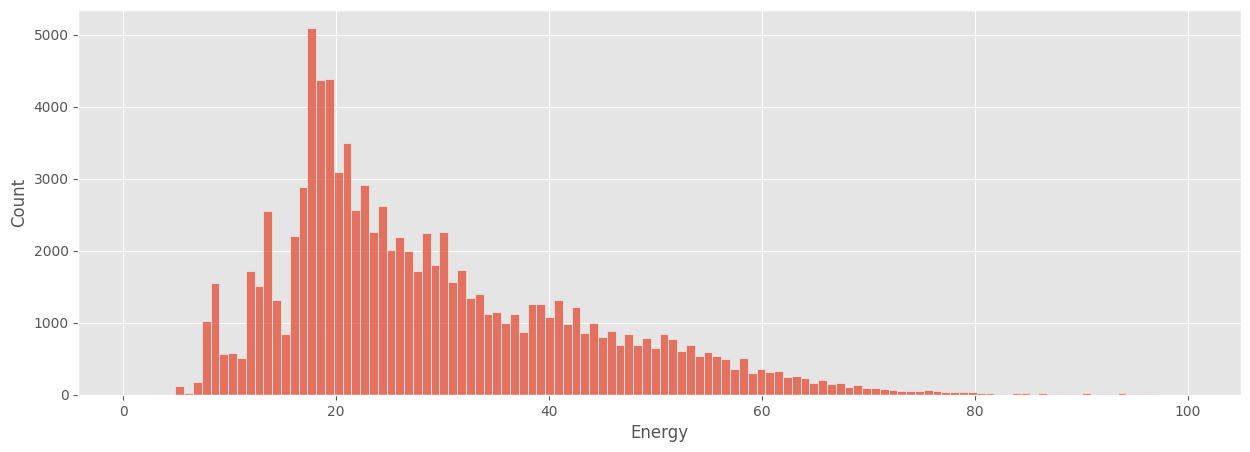

In [141]:
plt.figure(figsize=(15, 5))
sns.histplot(data['Energy'])
plt.show()

In [142]:
data['Time']=pd.to_datetime(data['Time'])

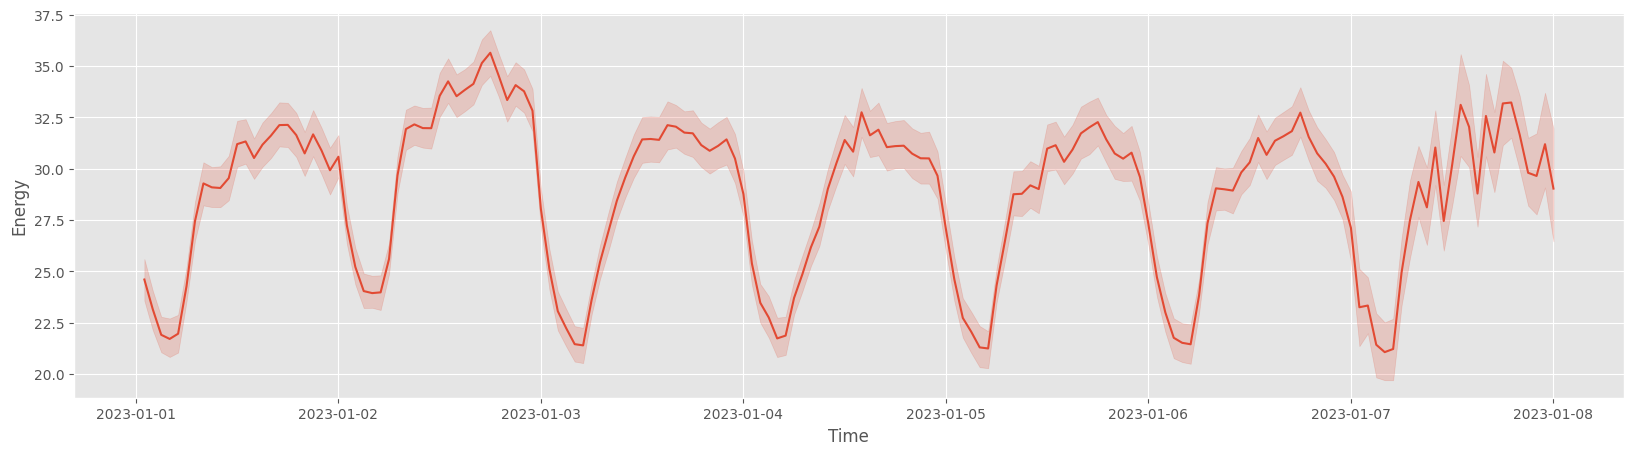

In [143]:
%matplotlib inline
from itertools import cycle

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
plt.figure(figsize=(20, 5))
sns.lineplot(data=data, x='Time', y='Energy')
plt.show()

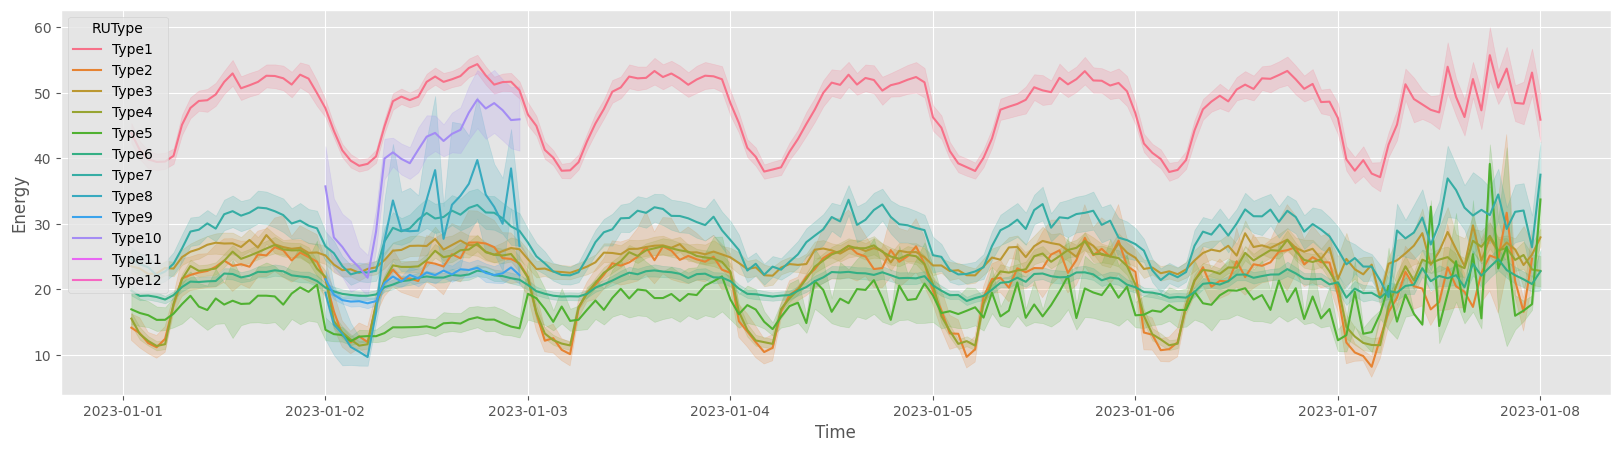

In [144]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=data, x='Time', y='Energy', hue='RUType')
plt.show()

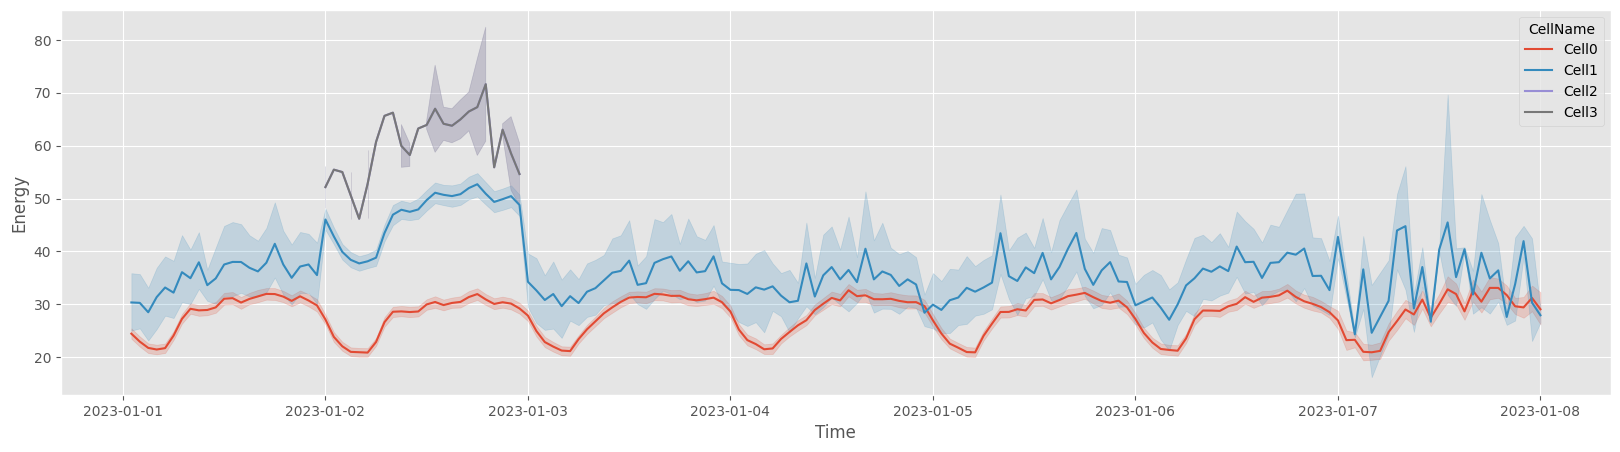

In [145]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=data, x='Time', y='Energy', hue='CellName')
plt.show()

In [146]:
df=data.drop(['BS_x','BS_y','ID','Time','Energy','split'],axis=1)
cat_cols=[col for col in df.columns if df[col].dtypes=='object']
cat_cols.append('Bandwidth')
cat_cols.append('Antennas')

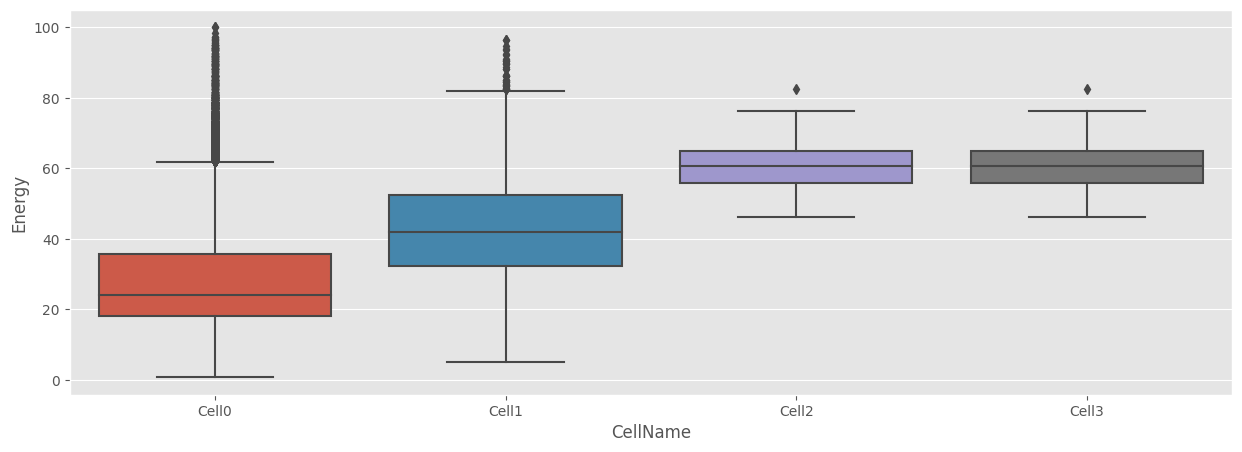

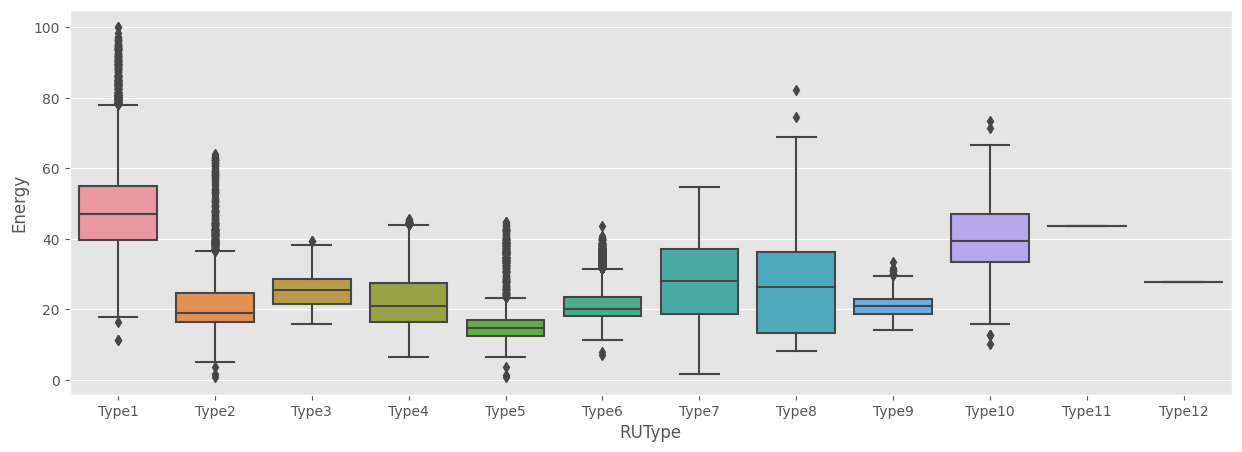

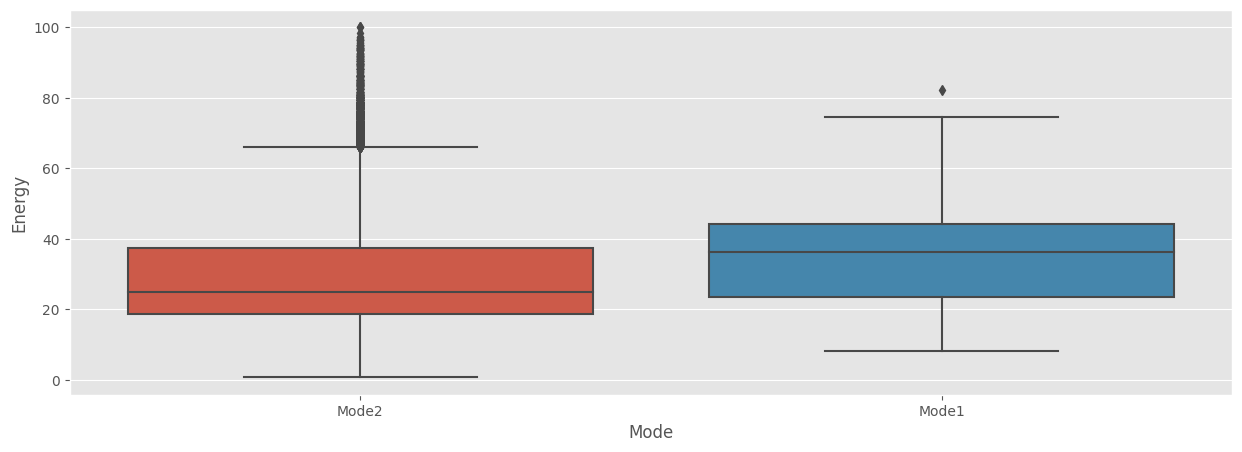

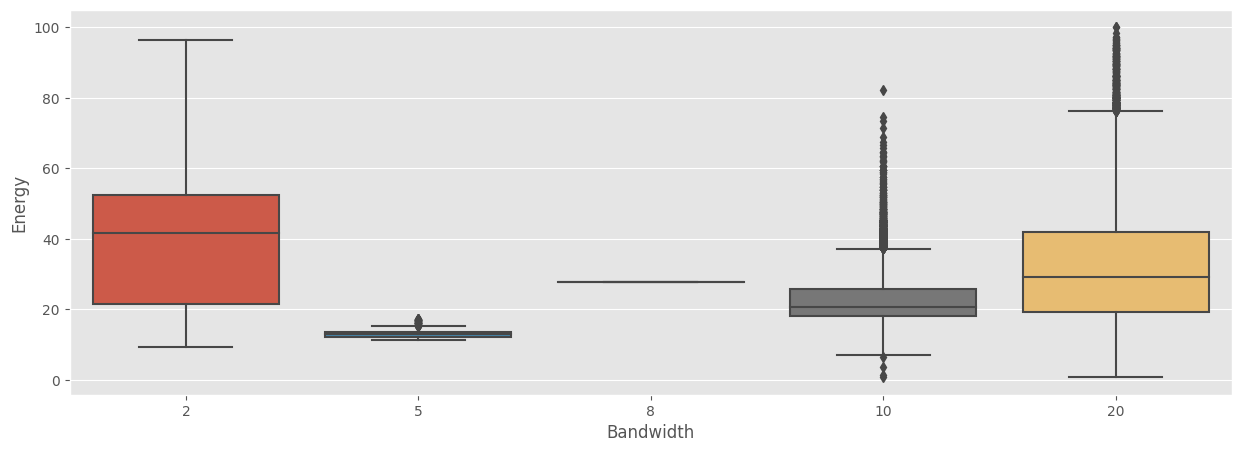

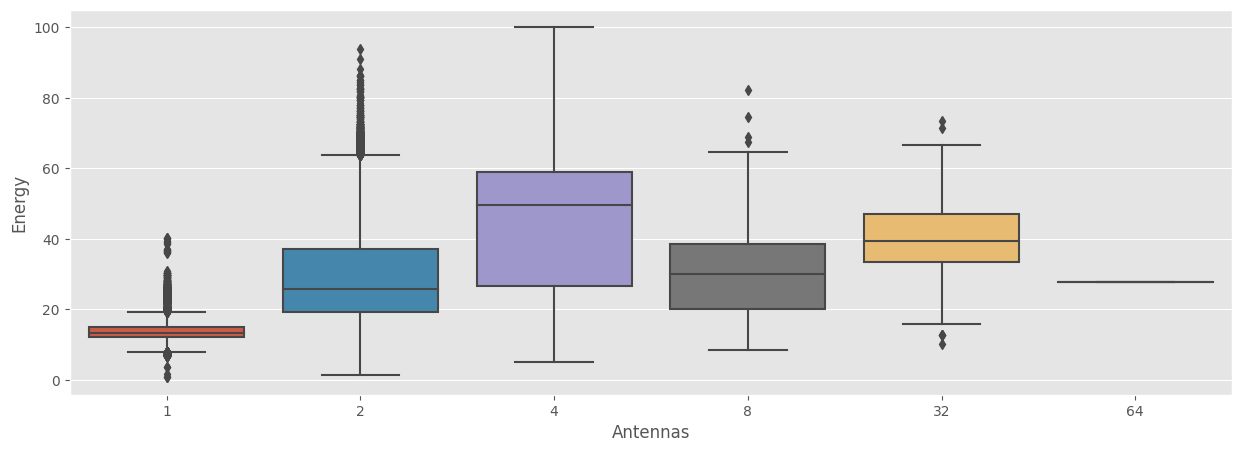

In [147]:
for col in cat_cols:
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=data, x=col, y='Energy')
    plt.show()

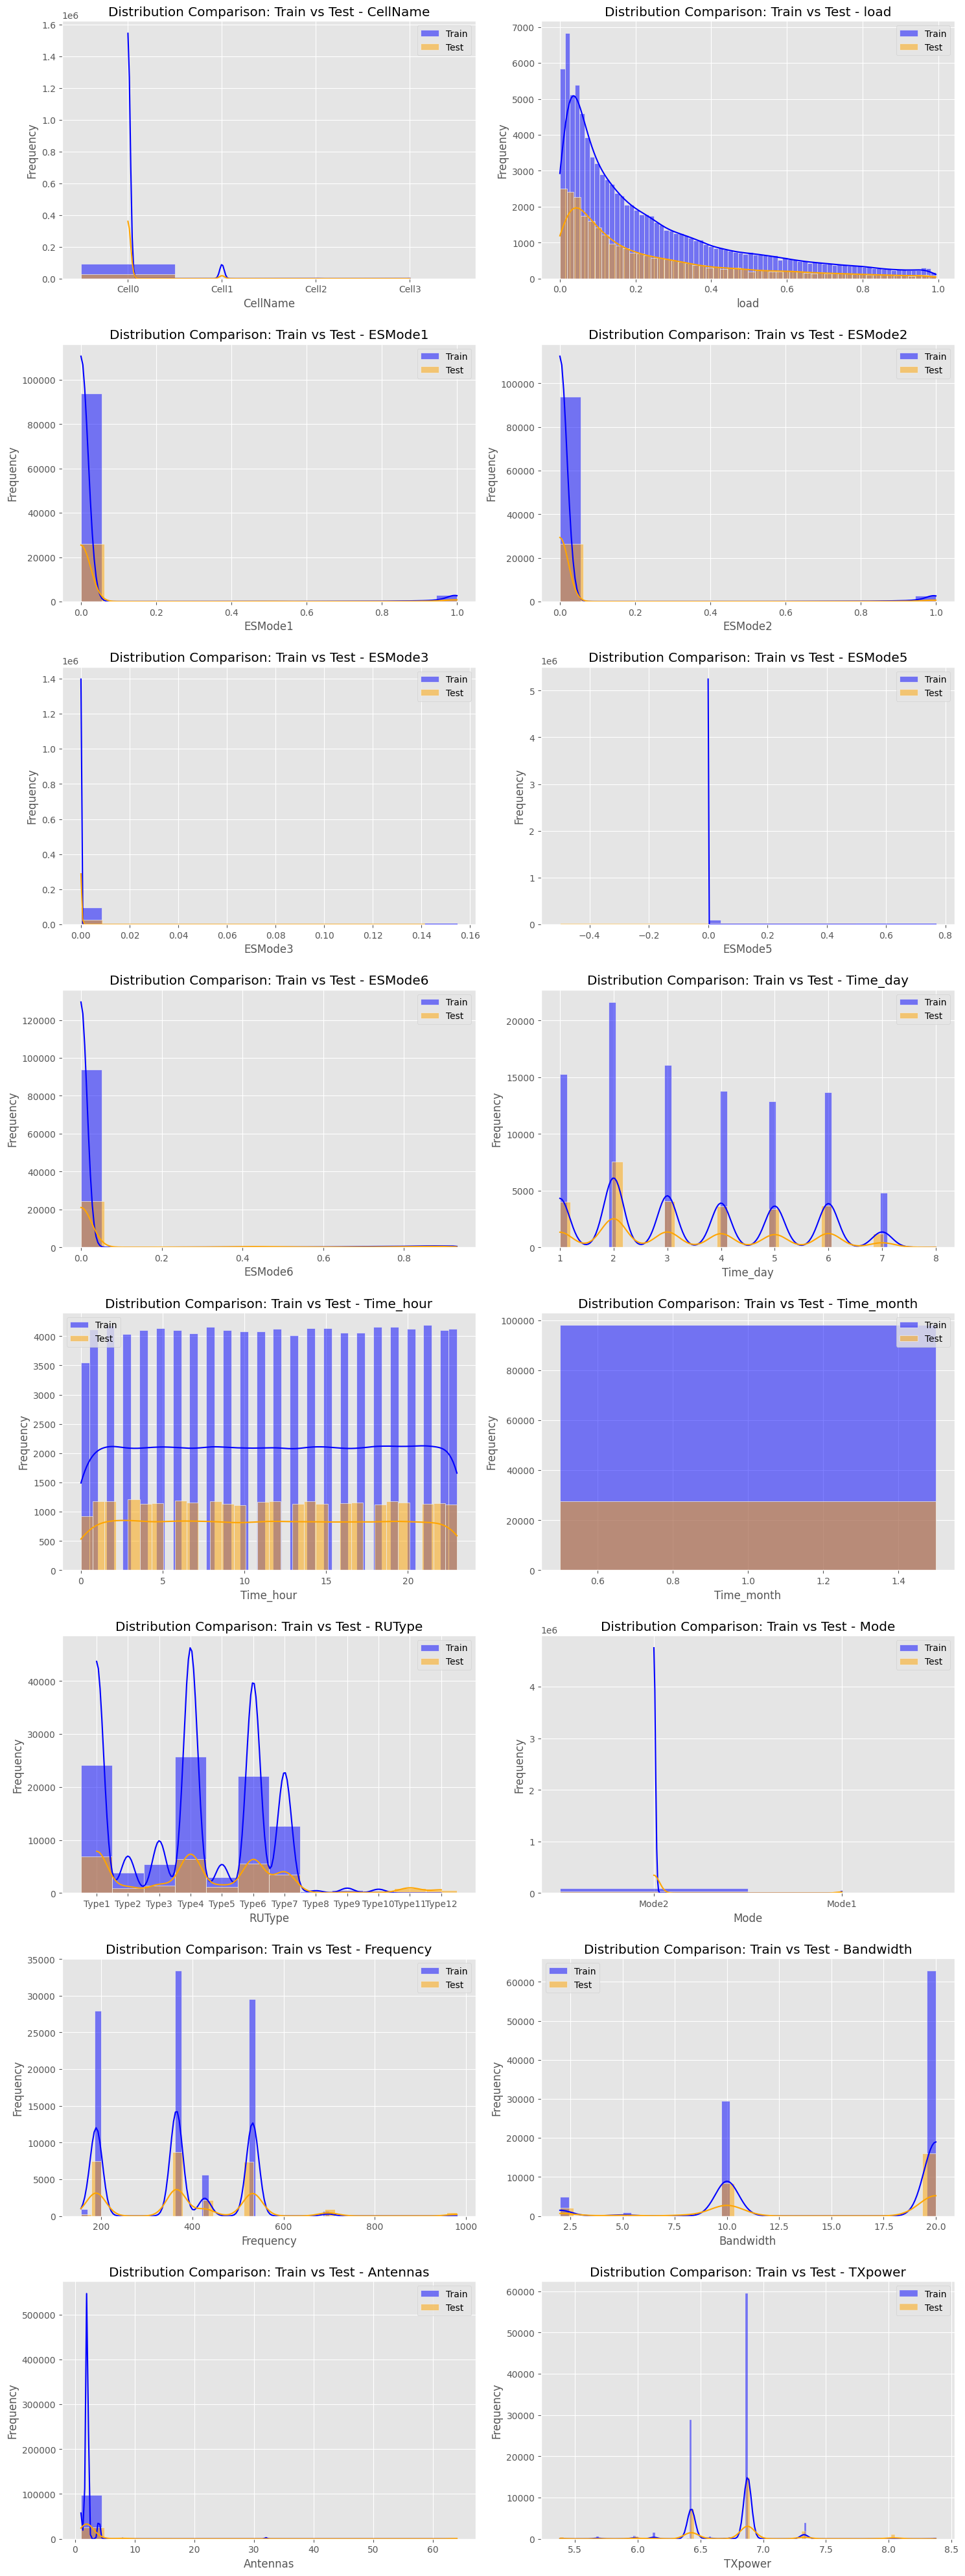

In [148]:

# Get a list of all features
all_features = df.columns

# Set up the figure and axis
num_features = len(all_features)
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_features + num_cols - 1) // num_cols

plt.figure(figsize=(15, 5 * num_rows))

for i, feature in enumerate(all_features):
    plt.subplot(num_rows, num_cols, i + 1)

    sns.histplot(data=data[data['split']=='train'], x=feature, color='blue', label='Train', kde=True)
    sns.histplot(data=data[data['split']=='test'], x=feature, color='orange', label='Test', kde=True)

    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title('Distribution Comparison: Train vs Test - ' + feature)
    plt.legend()

plt.tight_layout()
plt.show()


## Feature Engineering

In [149]:
data = data.rename(columns={'BS_x': 'BS'})
data.drop(['BS_y','split','Time'],axis=1,inplace=True)

In [150]:
data['lo_tx']=data['TXpower']/data['Antennas']
data['lo_fr']=data['load']*data['Frequency']
data['combination']=data['Frequency']/data['Frequency'].max()+data['TXpower']/data['TXpower'].max()-data['Antennas']/data['Antennas'].max()


In [151]:
lb=LabelEncoder()
data['Mode']=lb.fit_transform(data['Mode'])


In [152]:
def Agg(df,cols1,cols2) :
        for col1 in cols1 :
            for col2 in cols2 :
                df[f"{col1}_{col2}_mean"] = df.groupby(col1)[col2].transform('mean')
                df[f"{col1}_{col2}_std"] = df.groupby(col1)[col2].transform('std')
                df[f"{col1}_{col2}_max"] = df.groupby(col1)[col2].transform('max')
                df[f"{col1}_{col2}_min"] = df.groupby(col1)[col2].transform('min')
                df[f"{col1}_{col2}_median"] = df.groupby(col1)[col2].transform('median')
        return df
def AddQuantiles(df,cols1,cols2) :
        for col1 in cols1 :
            for col2 in cols2 :
                q75 = dict(df.groupby(col1)[col2].quantile(0.75))
                q25 = dict(df.groupby(col1)[col2].quantile(0.25))
                q90 = dict(df.groupby(col1)[col2].quantile(0.90))
                q10 = dict(df.groupby(col1)[col2].quantile(0.10))
                df[f"{col1}_{col2}_q75"] = df[col1].map(q75)
                df[f"{col1}_{col2}_q25"] = df[col1].map(q25)
                df[f"{col1}_{col2}_q90"] = df[col1].map(q90)
                df[f"{col1}_{col2}_q10"] = df[col1].map(q10)
        return df

In [153]:
data=Agg(data,['Time_hour'],['load','Frequency','Bandwidth','TXpower','lo_fr','lo_tx'])
data=Agg(data,['Time_day'],['load'])
data=Agg(data,['BS'],['load','Frequency','Antennas','Bandwidth','TXpower','lo_fr','lo_tx'])
data=Agg(data,['RUType'],['load','Frequency','Antennas','Bandwidth','TXpower','lo_fr','lo_tx'])





data=AddQuantiles(data,['Time_hour'],['Frequency','Bandwidth','TXpower','lo_fr','lo_tx'])
data=AddQuantiles(data,['BS'],['load','Frequency','Antennas','Bandwidth','TXpower','lo_fr','lo_tx'])
data=AddQuantiles(data,['RUType'],['load','Frequency','Antennas','Bandwidth','TXpower','lo_fr','lo_tx'])
data=AddQuantiles(data,['Time_day'],['load'])
data['count_cell'] = data.groupby('BS')['CellName'].transform('count')
data['count_type'] = data.groupby('RUType')['BS'].transform('count')



<ipython-input-152-da8cdaa7c388>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col1}_{col2}_min"] = df.groupby(col1)[col2].transform('min')
<ipython-input-152-da8cdaa7c388>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col1}_{col2}_median"] = df.groupby(col1)[col2].transform('median')
<ipython-input-152-da8cdaa7c388>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

In [154]:
dummies=pd.get_dummies(data['RUType'])
data=data.drop(['RUType'],axis=1)
data=pd.concat([data,dummies],axis=1)

In [155]:
data=data.fillna(0)

In [156]:
drop_features=['load','Frequency','Bandwidth',]
data.drop(drop_features,axis=1,inplace=True)

In [157]:
drop_agg=['Time_hour_Frequency_min','Time_hour_Frequency_max','Time_hour_TXpower_min','RUType_load_min','RUType_load_max','RUType_Antennas_mean']
data.drop(drop_agg,axis=1,inplace=True)

In [158]:
train=data[data['ID'].isin(ener_con['ID'])]
test=data[~(data['ID'].isin(ener_con['ID']))]

In [159]:
train=train.drop_duplicates(subset=['ID'],keep='first')
test=test.drop_duplicates(subset=['ID'],keep='first')

In [160]:
train.drop(['BS','CellName','ID'],axis=1,inplace=True)
test.drop(['BS','CellName','ID'],axis=1,inplace=True)

In [161]:
train

,ESMode1,ESMode2,ESMode3,ESMode5,ESMode6,Time_day,Time_hour,Time_month,Mode,Antennas,...,Type11,Type12,Type2,Type3,Type4,Type5,Type6,Type7,Type8,Type9
0,0.0,0.0,0.0,0.0,0.000000,1,1,1,1,4,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.000000,1,2,1,1,4,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.000000,1,3,1,1,4,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.000000,1,4,1,1,4,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.000000,1,5,1,1,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118737,0.0,0.0,0.0,0.0,0.781566,2,17,1,1,2,...,0,0,0,0,0,1,0,0,0,0
118738,0.0,0.0,0.0,0.0,0.804310,2,18,1,1,2,...,0,0,0,0,0,1,0,0,0,0
118741,0.0,0.0,0.0,0.0,0.846935,2,21,1,1,2,...,0,0,0,0,0,1,0,0,0,0
118742,0.0,0.0,0.0,0.0,0.856434,2,22,1,1,2,...,0,0,0,0,0,1,0,0,0,0


## Modelling

### Please do not run this cell
this script is for hyperparameters tunning and it takes time

In [ ]:

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train.drop('Energy',axis=1), train['Energy'], test_size=0.1, random_state=1234)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
num_rounds = 50000
def objective(trial):
    # Define hyperparameters to be tuned
    params = {
        'objective': 'regression',
        'metric': 'rae',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.01, 10.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),


    }
    # Train LightGBM model with current set of hyperparameters
    lgbm = lgb.train(params, train_data, num_rounds, valid_sets=[test_data])
    # Predict on test set and calculate MAE score
    y_pred = lgbm.predict(X_test)
    rmse = mean_absolute_error(y_test, y_pred)

    return rmse

# Set up the Optuna study and run trials
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Train LightGBM model with best set of hyperparameters found by Optuna
best_params = study.best_params
best_lgbm = lgb.LGBMRegressor(**best_params)
best_lgbm.fit(X_train, y_train, verbose=False)

# Predict on test set and calculate RMSE score
y_pred = best_lgbm.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('Best hyperparameters:', best_params)
print('Best MAE:', mae)

In [26]:
# best set of parameters
best_params={'learning_rate': 0.05014932711138855,
 'num_leaves': 82,
 'reg_alpha': 2.5639389256690515,
 'reg_lambda': 0.12523931338344882,
 'n_estimators': 3760}

In [28]:
from lightgbm import early_stopping


In [162]:

# Load data
X_train, X_test, y_train, y_test = train_test_split(train.drop('Energy',axis=1),train['Energy'] , test_size=0.2,random_state=0)
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Set hyperparameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 82,
    'learning_rate': 0.05014932711138855,
    'reg_alpha': 2.5639389256690515,
    'reg_lambda': 0.12523931338344882,
    'n_estimators': 3760,
    'early_stopping_rounds':100,
    # 'verbose_eval':200

}

# Train the model
num_rounds = 50000
model = lgb.train(params, train_data, num_rounds, valid_sets=[train_data,test_data],)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print('mae:', mae)


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7759
[LightGBM] [Info] Number of data points in the train set: 74103, number of used features: 177
[LightGBM] [Info] Start training from score 28.112363
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2412]	training's l1: 0.586872	valid_1's l1: 1.06895
mae: 1.0689473550827935


<ipython-input-39-420aca3505d0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_50_features['Importance_percentage'] = (top_50_features['Importance'] / top_50_features['Importance'].sum()) * 100


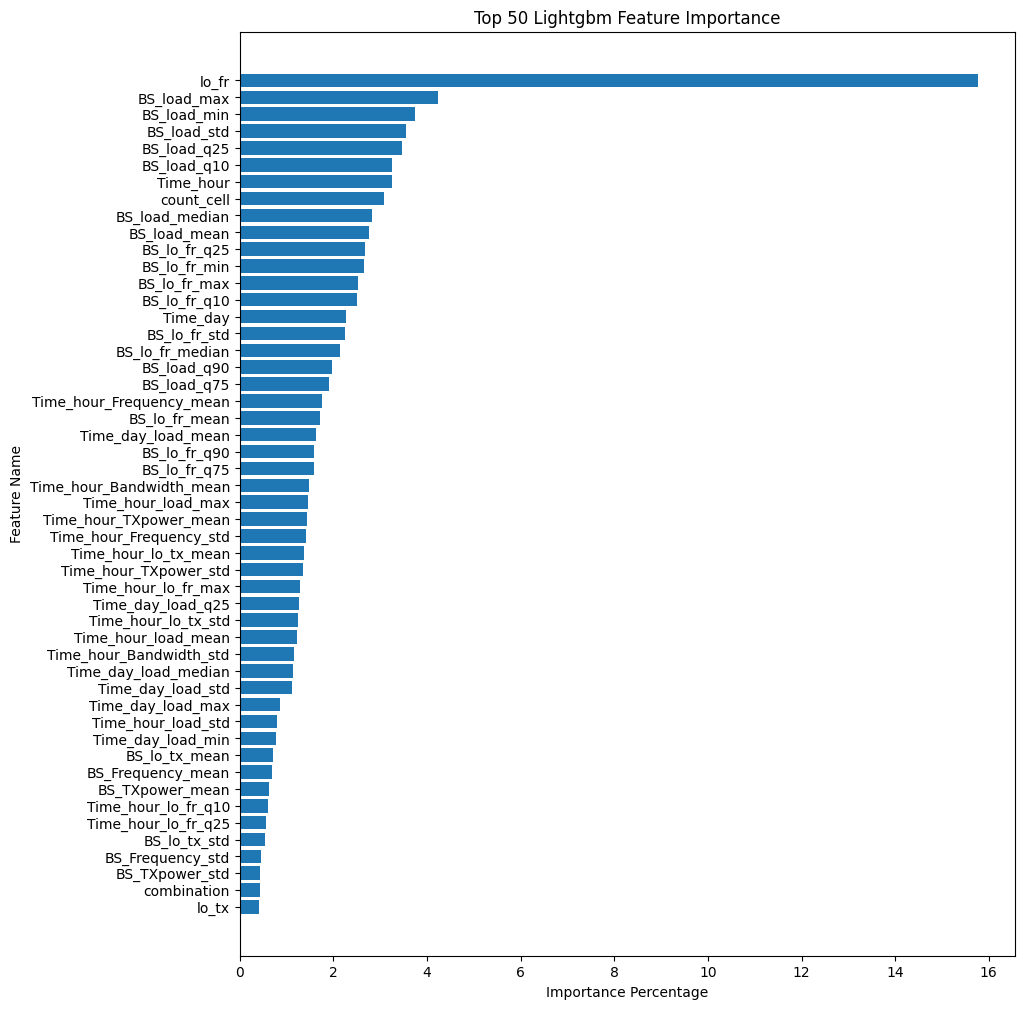

In [39]:
#feature importance catboost
feature_importance = model.feature_importance()
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_50_features = feature_importance_df.head(50)
top_50_features['Importance_percentage'] = (top_50_features['Importance'] / top_50_features['Importance'].sum()) * 100
# Create a bar plot of the top 50 features and their percentages
plt.figure(figsize=(10, 12))
plt.barh(top_50_features['Feature'], top_50_features['Importance_percentage'])
plt.xlabel('Importance Percentage')
plt.ylabel('Feature Name')
plt.title('Top 50 Lightgbm Feature Importance')
plt.gca().invert_yaxis()  # Reverse the order to display the most important features at the top
plt.show()

### Please do not run this cell
this script is for hyperparameters tunning and it takes time

In [ ]:

X_train, X_valid, y_train, y_valid = train_test_split(train, ener_con['Energy'], test_size=0.2, random_state=42)
train_pool = Pool(X_train, label=y_train)
valid_pool = Pool(X_valid, label=y_valid)

def objective(trial):
    params = {
        'loss_function':'MAE',
        'iterations': trial.suggest_int('iterations', 50000, 70000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'task_type':'GPU'
        # Add more hyperparameters to tune
    }

    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=500)

    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    return mae

if __name__ == "__main__":
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)  # You can adjust the number of trials

    print('Number of finished trials:', len(study.trials))
    print('Best trial:')
    trial = study.best_trial

    print('Value: ', trial.value)
    print('Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

    # Use the best parameters to train the final model
    best_params = study.best_params
    final_model = CatBoostRegressor(**best_params)
    final_model.fit(train_pool, eval_set=valid_pool, verbose=500)


In [33]:
#best parameters for catboost
''' if you gonna train the catboost model on cpu please remove 'task_type':'GPU' and if so
it will take sometime.
'''
cat_params={'iterations': 61666,
            'depth': 5,
            'learning_rate': 0.054404170700668457,
            'l2_leaf_reg': 0.101929807646990755,
            'bagging_temperature': 0.7805657381624727,
            'random_strength': 0.7982157709406001,
            'border_count': 197,
             'loss_function':'MAE',
            'task_type':'GPU',
              }

In [34]:


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train.drop('Energy',axis=1), train['Energy'], test_size=0.2, random_state=42,)

# Define the CatBoostRegressor model
model1 = CatBoostRegressor(**cat_params,early_stopping_rounds=50)

# Train the model
model1.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=500)

# Make predictions on the testing data
y_pred = model1.predict(X_test)

# Compute the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Print the mean squared error
print("Mean Absolute Error:", np.sqrt(mae))


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 10.6269955	test: 10.4950720	best: 10.4950720 (0)	total: 27.3ms	remaining: 28m
500:	learn: 5.0225299	test: 4.9604458	best: 4.9604458 (500)	total: 2.4s	remaining: 4m 52s
1000:	learn: 3.1631462	test: 3.1560261	best: 3.1560261 (1000)	total: 4.07s	remaining: 4m 6s
1500:	learn: 2.5645223	test: 2.5751979	best: 2.5751979 (1500)	total: 5.76s	remaining: 3m 51s
2000:	learn: 2.3408581	test: 2.3568332	best: 2.3568332 (2000)	total: 7.39s	remaining: 3m 40s
2500:	learn: 2.1830204	test: 2.2058916	best: 2.2058916 (2500)	total: 9.06s	remaining: 3m 34s
3000:	learn: 2.0494398	test: 2.0764979	best: 2.0764979 (3000)	total: 11.3s	remaining: 3m 40s
3500:	learn: 1.9312585	test: 1.9597169	best: 1.9597169 (3500)	total: 14.6s	remaining: 4m 1s
4000:	learn: 1.8307529	test: 1.8629462	best: 1.8629462 (4000)	total: 16.3s	remaining: 3m 54s
4500:	learn: 1.7441630	test: 1.7796574	best: 1.7796574 (4500)	total: 17.9s	remaining: 3m 47s
5000:	learn: 1.6672357	test: 1.7058972	best: 1.7058972 (5000)	total: 19.6s	remai

/tmp/ipykernel_28/2452720103.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_50_features['Importance_percentage'] = (top_50_features['Importance'] / top_50_features['Importance'].sum()) * 100


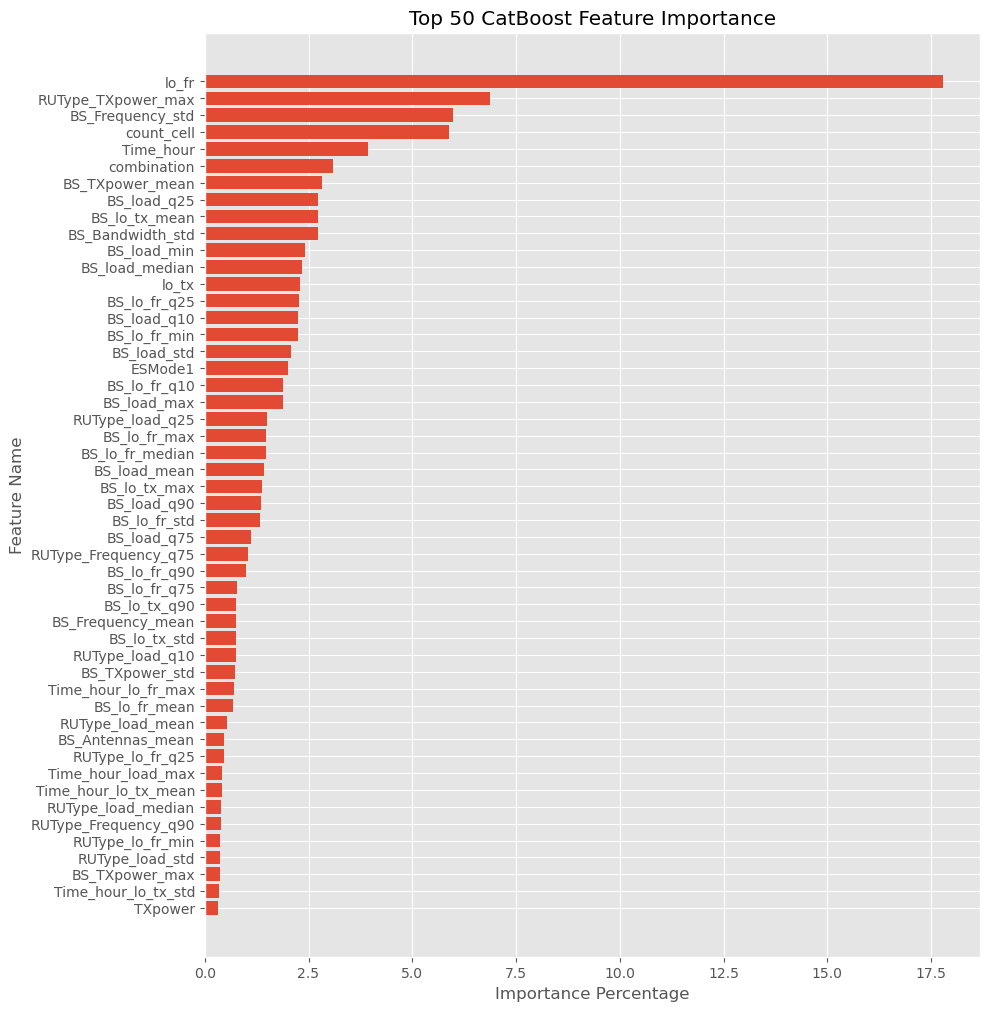

In [ ]:
#feature importance catboost
feature_importance = model1.get_feature_importance()
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_50_features = feature_importance_df.head(50)
top_50_features['Importance_percentage'] = (top_50_features['Importance'] / top_50_features['Importance'].sum()) * 100
# Create a bar plot of the top 50 features and their percentages
plt.figure(figsize=(10, 12))
plt.barh(top_50_features['Feature'], top_50_features['Importance_percentage'])
plt.xlabel('Importance Percentage')
plt.ylabel('Feature Name')
plt.title('Top 50 CatBoost Feature Importance')
plt.gca().invert_yaxis()  # Reverse the order to display the most important features at the top
plt.show()

In [ ]:
test['Energy']

5         0.0
10        0.0
11        0.0
12        0.0
22        0.0
         ... 
118763    0.0
118764    0.0
118765    0.0
118766    0.0
118767    0.0
Name: Energy, Length: 26139, dtype: float64

In [163]:
pred1=model.predict(test.drop('Energy',axis=1))
pred1

array([62.94632771, 72.69487716, 73.33478136, ..., 18.24563542,
       18.38937337, 17.39729478])

In [ ]:
pred2=model1.predict(test.drop('Energy',axis=1))
pred2

array([59.57453713, 73.6778437 , 73.89012494, ..., 16.04667465,
       15.66559563, 15.48211772])

In [ ]:
# this submissions gives the  score 0.071764620
#did not choose this
sub['Energy']=pred1*0.85+pred2*0.15

In [166]:
# this submissions gives the private score 0.070974957
sub['Energy']=pred1

<ipython-input-167-be5d7abd5fd0>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sub['Energy'])


<Axes: xlabel='Energy', ylabel='Density'>

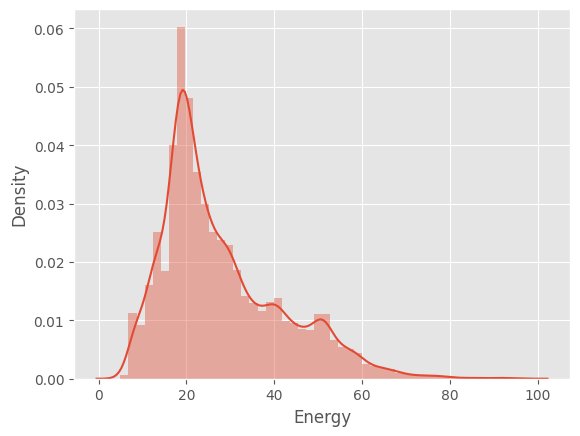

In [167]:
sns.distplot(sub['Energy'])

In [168]:
sub

,ID,Energy
0,2023-01-01 06:00:00_B_0,62.946328
1,2023-01-01 11:00:00_B_0,72.694877
2,2023-01-01 12:00:00_B_0,73.334781
3,2023-01-01 13:00:00_B_0,75.019164
4,2023-01-01 23:00:00_B_0,79.236118
...,...,...
26134,2023-01-02 19:00:00_B_1019,18.313685
26135,2023-01-02 20:00:00_B_1019,18.161331
26136,2023-01-02 21:00:00_B_1019,18.245635
26137,2023-01-02 22:00:00_B_1019,18.389373


In [ ]:
sub.to_csv('final_submission.csv',index=False)